In [1]:
using Plots
include("coevolution_network_base.jl")
using .CoevolutionNetworkBase
using Printf
theme(:dracula)

In [114]:
# Parameters
L = 40.0
dx = 0.05
x = -L/2:dx:L/2-dx
r = 2.5
M = 15
beta = 2.5
alpha = 0.0
gamma = 1.0
D = 0.01
Nh = 2 * 10^6

# Initialize viral and immune densities
viral_density = zeros(Float64, length(x))
# viral_density[Int(round(length(x)/2))] = 100/dx

initial_variance = 0.1
viral_density .= 100/sqrt(2 * pi * initial_variance) .* exp.(-x.^2/2/initial_variance)
viral_density2 = zeros(Float64, length(x))
immune_density = zeros(Float64, length(x))

# Create Population instances
population = Population(L, dx, r, M, beta, alpha, gamma, D, Nh, viral_density, immune_density;stochastic=true, sigma=sqrt(20))
population2 = Population(L, dx, r, M, beta, alpha, gamma, D, Nh, viral_density2, immune_density; stochastic=true, sigma=sqrt(20))
populations = [population, population2]

# populations[1] = Population(L, dx, r, M, beta, alpha, gamma, D, Nh, viral_density, immune_density;stochastic=true)

# Create Network instance
migration_matrix = 1e-4 * ones(size(populations,1),size(populations,1)) # Define an appropriate migration matrix
println(size(migration_matrix,1))
network = Network(populations, migration_matrix)

# Create Simulation instance
dt = 0.05 # Define an appropriate time step size
duration = 80.0 # Define an appropriate simulation duration
simulation = Simulation(network, dt, duration; thin_by=20)

@time begin
    # single_step_evolve!(population,dt)
    run_simulation!(simulation)
end

println(migration_matrix)

2
 34.817850 seconds (1 allocation: 736 bytes)
[0.0001 0.0001; 0.0001 0.0001]


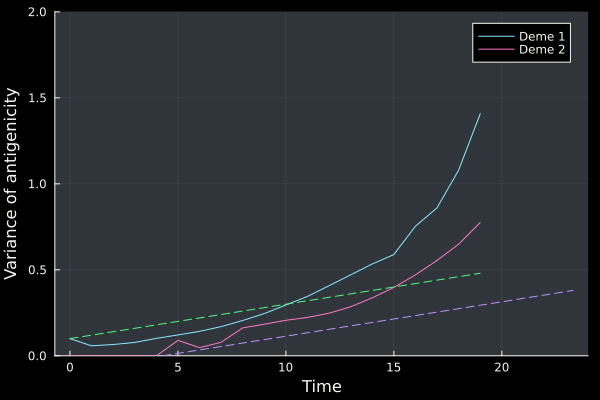

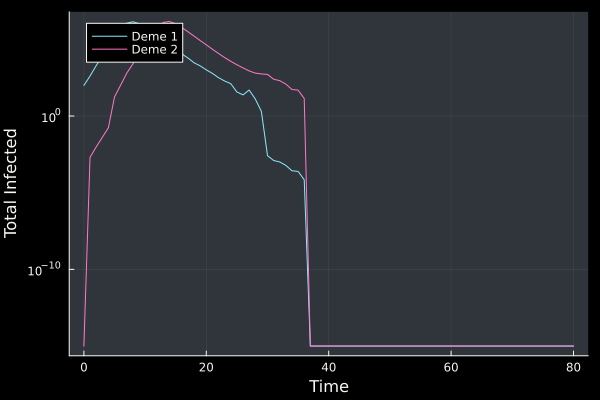

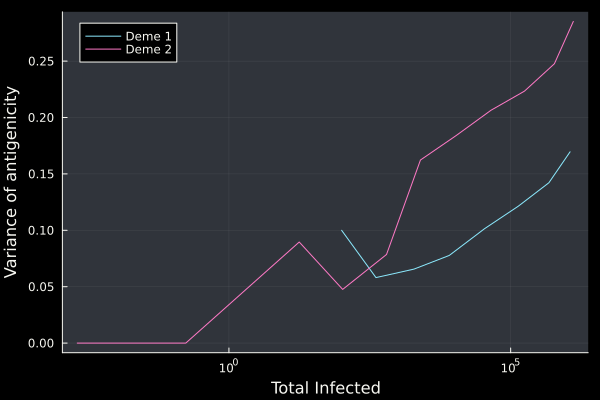

In [115]:
variances_per_deme = calculate_antigenic_variance_per_deme(simulation)
total_infected_per_deme = calculate_total_infected_per_deme(simulation)

# Number of demes
num_demes = size(total_infected_per_deme, 1)

# Plot for Variance of Antigenicity vs Time
treg = simulation.duration_times .< 20
p = plot(;xlabel="Time", ylabel="Variance of antigenicity", background_color=:black)
for deme in 1:num_demes
    plot!(p, simulation.duration_times[treg], variances_per_deme[deme, treg], label="Deme $deme")
end
plot!(p, simulation.duration_times[treg], 0.1 .+ 2 * D * simulation.duration_times[treg], linestyle=:dash, label=:none)
plot!(p, simulation.duration_times[treg] .+ 4.3, 2 * D * simulation.duration_times[treg], linestyle=:dash, label=:none)
plot!(p, ylim=(0,2))
display(p)

# Plot for Total Infected vs Time
treg = simulation.duration_times .< 90
p2 = plot(xlabel="Time", ylabel="Total Infected", background_color=:black, yscale=:log, legend=:topleft)
# Manually setting y-axis ticks for each order of magnitude
# yticks = [10^i for i in 0:7]; plot!(p2, yticks=yticks)
for deme in 1:num_demes
    plot!(p2, simulation.duration_times[treg], total_infected_per_deme[deme, treg] .+ 10^-15, label="Deme $deme")
end
# plot!(p2, simulation.duration_times[treg] .- 4.3, total_infected_per_deme[2, treg] .+ 10^-15, label="Deme 2, shifted", xlim=(0,Inf))
display(p2)

p3 = plot(xlabel="Total Infected", ylabel="Variance of antigenicity", xscale=:log10, legend=:topleft, background_color=:black)
for deme in 1:num_demes
    # Find the index where the total infected per deme attains its maximum for the first time
    max_index = findfirst(==(maximum(total_infected_per_deme[deme, :])), total_infected_per_deme[deme, :])

    # Create the Boolean mask
    # reg = (total_infected_per_deme[deme, :] .> 100) .& (variances_per_deme[deme, :] .> 0) .& (1:length(total_infected_per_deme[deme, :]) .< max_index)
    reg = (total_infected_per_deme[deme, :] .> 0) .& (simulation.duration_times .<  simulation.duration_times[argmax(total_infected_per_deme[deme, 1:50])])
    
    # Plot using the mask
    plot!(p3, total_infected_per_deme[deme, reg], variances_per_deme[deme, reg], label="Deme $deme")
end
display(p3)

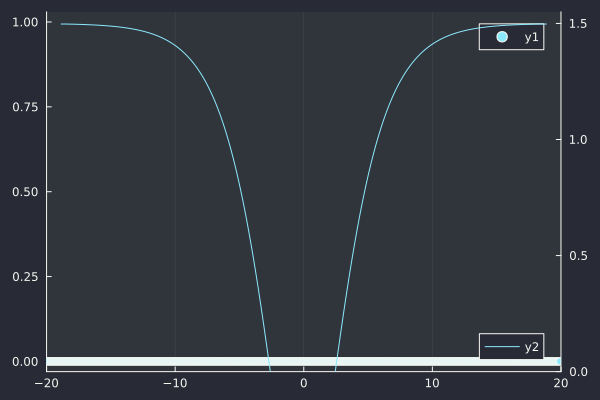

In [116]:
t_idx = 80
p = scatter(x, simulation.trajectory[t_idx].populations[1].viral_density, xlim=(-20,20))
p2 = twinx(p)
plot!(p2, x, simulation.trajectory[t_idx].populations[1].fitness, ylim =(0, 1.55))

In [73]:
Base.summarysize(simulation) / 1024 / 1024

7.112678527832031